In [7]:
from __future__ import division

from faculty_hiring.misc.util import *
from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE and such
from faculty_hiring.misc.gaussian_kde import gaussian_kde
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.parse import load
from faculty_hiring.parse.nces import parse_phds_awarded
from faculty_hiring.misc.subfield import topic_descriptions, longer_topic_descriptions, num_topics 

from scipy.stats.stats import pearsonr, mannwhitneyu, ttest_ind
from scipy.stats import ttest_ind, ks_2samp, chi2_contingency, mannwhitneyu
from scipy.special import gamma as gammaf
from sklearn.linear_model import LinearRegression
from collections import Counter
from fuzzywuzzy import fuzz
import statsmodels.api as sm
import numpy as np
import scipy as sp
import os

# File locations
faculty_file = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/faculty_cs_CURRENT.txt'
inst_file = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/inst_cs_CURRENT.txt'
figures_dir = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/notebooks-productivity/figures/'
nces_table = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/nces_table.txt'

# (Optional, these are for loading publication profiles)
dblp_dir = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/profiles_DBLP_Nov16/'

In [38]:
inst = institution_parser.parse_institution_records(open(inst_file))
asst_faculty = load.load_assistant_profs(open(faculty_file), inst, ranking='pi')
load.load_all_publications(asst_faculty, dblp_dir)

## General trends

In [6]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), sp.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

def median_confidence_interval(data):
    vals = np.sort(data)
    n = float(len(data))
    x = (1.96*np.sqrt(n))/2
    lower_ind = int(n-np.ceil((n/2)-x))
    upper_ind = int(n-np.floor(1+(n/2)+x))
    med = np.median(data)
    upper = vals[upper_ind]
    lower = vals[lower_ind]
    return med, lower, upper

# Normalization

It seems like there ought to be some normalization to account for the average/median number of publications each year. The more recent folks are going to have higher quantities due to higher publication rates, increased visibility, etc.

The number of publications per person has grown by one every 9.6 years.
Slope:  [ 0.10438616]


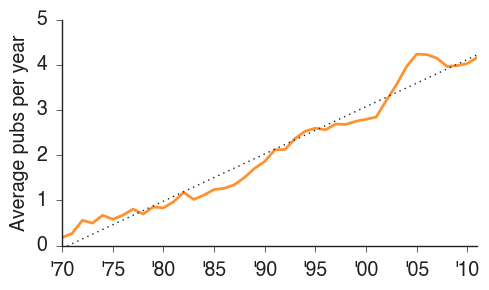

In [16]:
all_before = 2012
all_after = 1970
all_years = np.arange(all_after, all_before)
exclude_maps = False

counts = {year:[] for year in all_years}

for person in asst_faculty:
    # Do they fall in the specified range of years?
    start = int(person.first_asst_job_year)
    if start > all_before or start < all_after:
        continue
    
    if 'dblp_pubs' in person:
        pubs = person['dblp_pubs']
    else:
        pubs = []
    
    years = []
    for pub in pubs:
        if 'year' in pub and pub['year'] >= start and \
           pub['pub_type'] in ['inproceedings', 'article']:
            if exclude_maps and pub['author_role'] == MAP: continue  # Skip MAPs
            years.append(pub['year'])
    pub_years = Counter(years)
    for year in xrange(person.first_asst_job_year, all_before):
        counts[year].append(pub_years[year])
        
mean_counts = {year:np.mean(counts[year]) for year in counts}
med_counts = {year:np.median(counts[year]) for year in counts}
std_counts = {year:np.std(counts[year]) for year in counts}

# Make the figure
fig, ax = plt.subplots(figsize=(5,3))

years = np.arange(1970, 2012)
traj = np.array([mean_counts[y] for y in years])
ax.plot(years, traj, color=ACCENT_COLOR_1, linewidth=LINE_WIDTH)
hide_right_top_axis(ax)
ax.set_ylabel('Average pubs per year', fontsize=LABEL_SIZE)
ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)

xticks = np.arange(1970, 2020, 5)
ax.set_xticks(xticks)
ax.set_xticklabels(["'" + str(y)[-2:] for y in xticks])

x = np.array([1970, 2011])
regr = LinearRegression()
regr.fit(all_years[:,np.newaxis], [mean_counts[y] for y in all_years])
ax.plot(x, x*regr.coef_ + regr.intercept_, ':', color=ALMOST_BLACK)

finalize(ax)
ax.set_ylim(0,5)

print 'The number of publications per person has grown by one every %.1f years.' % (1/regr.coef_)
print 'Slope: ', regr.coef_

plt.savefig(figures_dir + 'prod_numb.pdf')
plt.show()

The average number of authors per paper has grown by one every 17.1 years.
Slope:  [ 0.05835604]


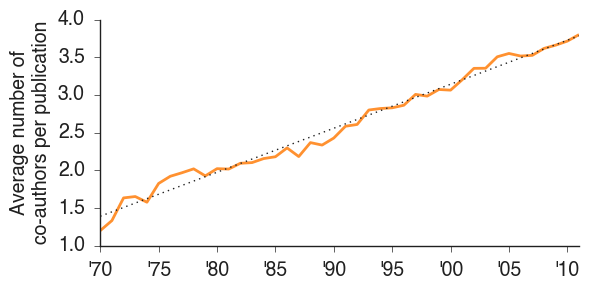

In [17]:
all_before = 2012
all_after = 1970

counts = {year:[] for year in xrange(all_after, all_before)}
male_counts = {year:[] for year in xrange(all_after, all_before)}
female_counts = {year:[] for year in xrange(all_after, all_before)}

for person in asst_faculty:
    # Do they fall in the specified range of years?
    start = int(person.first_asst_job_year)
    if start > all_before or start < all_after:
        continue
    
    if 'dblp_pubs' in person:
        pubs = person['dblp_pubs']
    else:
        pubs = []
    
    if person.is_female:
        gender_counts = female_counts
    else:
        gender_counts = male_counts
    
    years = []
    for pub in pubs:
        if 'year' in pub and pub['year'] >= start and pub['year'] < 2012 and \
           pub['pub_type'] in ['inproceedings', 'article']:
            counts[pub['year']].append(len(pub['authors']))
            gender_counts[pub['year']].append(len(pub['authors']))
        
mean_counts = {year:np.mean(counts[year]) for year in counts}
med_counts = {year:np.median(counts[year]) for year in counts}
std_counts = {year:np.std(counts[year]) for year in counts}

male_mean_counts = {year:np.mean(male_counts[year]) for year in counts}
female_mean_counts = {year:np.mean(female_counts[year]) for year in counts}

# Make the figure
fig, ax = plt.subplots(figsize=(6,3))

years = np.arange(1970, 2012)
traj = np.array([mean_counts[y] for y in years])
ax.plot(years, traj, color=ACCENT_COLOR_1, linewidth=LINE_WIDTH)
hide_right_top_axis(ax)
ax.set_ylabel('Average number of\nco-authors per publication', fontsize=LABEL_SIZE)
ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)

xticks = np.arange(1970, 2020, 5)
ax.set_xticks(xticks)
ax.set_xticklabels(["'" + str(y)[-2:] for y in xticks])

x = np.array([1970, 2011])
regr = LinearRegression()
regr.fit(all_years[:,np.newaxis], [mean_counts[y] for y in all_years])
ax.plot(x, x*regr.coef_ + regr.intercept_, ':', color=ALMOST_BLACK)

finalize(ax)

print 'The average number of authors per paper has grown by one every %.1f years.' % (1/regr.coef_)
print 'Slope: ', regr.coef_

plt.savefig(figures_dir + 'prod_coauthors.pdf')
plt.show()

The number of (fractional) publications per person has grown by one every 31.9 years.
Slope:  [ 0.03135343]


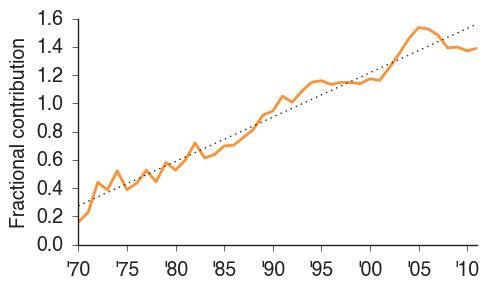

In [18]:
all_before = 2012
all_after = 1970
all_years = np.arange(all_after, all_before)

counts = {year:[] for year in all_years}

for person in asst_faculty:
    # Do they fall in the specified range of years?
    start = int(person.first_asst_job_year)
    if start > all_before or start < all_after:
        continue
    
    if 'dblp_pubs' in person:
        pubs = person['dblp_pubs']
    else:
        pubs = []
    
    contr_years = Counter()
    for pub in pubs:
        if 'year' in pub and pub['year'] >= start and \
           pub['pub_type'] in ['inproceedings', 'article']:
            contr = 1./len(pub['authors'])
            contr_years[pub['year']] += contr

    for year in xrange(person.first_asst_job_year, all_before):
        counts[year].append(contr_years[year])
        
mean_counts = {year:np.mean(counts[year]) for year in counts}
med_counts = {year:np.median(counts[year]) for year in counts}
std_counts = {year:np.std(counts[year]) for year in counts}

# Make the figure
fig, ax = plt.subplots(figsize=(5,3))

years = np.arange(1970, 2012)
traj = np.array([mean_counts[y] for y in years])
ax.plot(years, traj, color=ACCENT_COLOR_1, linewidth=LINE_WIDTH)
#ax.text(1995, 2.5, r'$\leftarrow$ Trump Orange')
hide_right_top_axis(ax)
ax.set_ylabel('Fractional contribution', fontsize=LABEL_SIZE)
ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)

xticks = np.arange(1970, 2020, 5)
ax.set_xticks(xticks)
ax.set_xticklabels(["'" + str(y)[-2:] for y in xticks])

x = np.array([1970, 2011])
regr = LinearRegression()
regr.fit(all_years[:,np.newaxis], [mean_counts[y] for y in all_years])
ax.plot(x, x*regr.coef_ + regr.intercept_, ':', color=ALMOST_BLACK)

finalize(ax)

print 'The number of (fractional) publications per person has grown by one every %.1f years.' % (1/regr.coef_)
print 'Slope: ', regr.coef_

#plt.savefig(figures_dir + 'prod_coauthors.pdf')
plt.show()

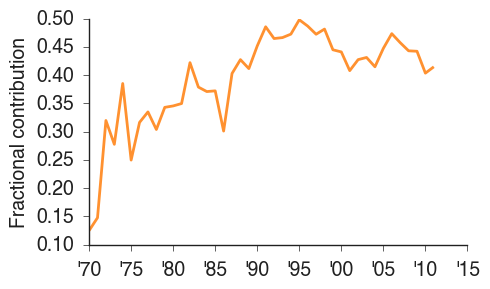

In [22]:
# Fractional contribution, just Journal Articles

all_before = 2012
all_after = 1970
all_years = np.arange(all_after, all_before)

counts = {year:[] for year in all_years}

for person in asst_faculty:
    # Do they fall in the specified range of years?
    start = int(person.first_asst_job_year)
    if start > all_before or start < all_after:
        continue
    
    if 'dblp_pubs' in person:
        pubs = person['dblp_pubs']
    else:
        pubs = []
    
    contr_years = Counter()
    for pub in pubs:
        if 'year' in pub and pub['year'] >= start and \
            pub['pub_type'] == 'article':
            contr = 1./len(pub['authors'])
            contr_years[pub['year']] += contr

    for year in xrange(person.first_asst_job_year, all_before):
        counts[year].append(contr_years[year])
        
mean_counts = {year:np.mean(counts[year]) for year in counts}
med_counts = {year:np.median(counts[year]) for year in counts}
std_counts = {year:np.std(counts[year]) for year in counts}

# Make the figure
fig, ax = plt.subplots(figsize=(5,3))

years = np.arange(1970, 2012)
traj = np.array([mean_counts[y] for y in years])
ax.plot(years, traj, color=ACCENT_COLOR_1, linewidth=LINE_WIDTH)
#ax.text(1995, 2.5, r'$\leftarrow$ Trump Orange')
hide_right_top_axis(ax)
ax.set_ylabel('Fractional contribution', fontsize=LABEL_SIZE)
ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)

xticks = np.arange(1970, 2020, 5)
ax.set_xticks(xticks)
ax.set_xticklabels(["'" + str(y)[-2:] for y in xticks])

x = np.array([1970, 2011])
regr = LinearRegression()
regr.fit(all_years[:,np.newaxis], [mean_counts[y] for y in all_years])
#ax.plot(x, x*regr.coef_ + regr.intercept_, ':', color=ALMOST_BLACK)

finalize(ax)

#print 'The number of (fractional) publications per person has grown by one every %.1f years.' % (1/regr.coef_)
#print 'Slope: ', regr.coef_

plt.show()

### Fractional contribution, years since hire

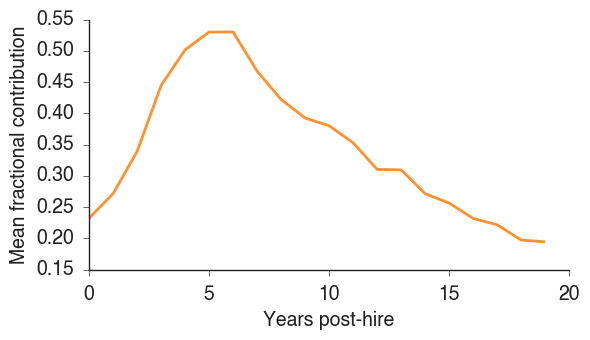

In [25]:
all_before = 2012
all_after = 1970
max_plot = 20
all_years = np.arange(max_plot)

counts = {year:[] for year in all_years}

for person in asst_faculty:
    # Do they fall in the specified range of years?
    start = int(person.first_asst_job_year)
    if start > all_before or start < all_after:
        continue
    
    if 'dblp_pubs' in person:
        pubs = person['dblp_pubs']
    else:
        pubs = []
    
    contr_years = Counter()
    for pub in pubs:
        if 'year' in pub and pub['year'] >= start and \
            pub['pub_type'] == 'article':
            
            year_diff = pub['year'] - start
            contr = 1./len(pub['authors'])
            contr_years[year_diff] += contr
            
    for year in xrange(max_plot):
        counts[year].append(contr_years[year])
        
mean_counts = {year:np.mean(counts[year]) for year in counts}
med_counts = {year:np.median(counts[year]) for year in counts}
std_counts = {year:np.std(counts[year]) for year in counts}

# Make the figure
fig, ax = plt.subplots(figsize=(6,3.5))

years = np.arange(max_plot)
traj = np.array([mean_counts[y] for y in years])
ax.plot(years, traj, color=ACCENT_COLOR_1, linewidth=LINE_WIDTH)

hide_right_top_axis(ax)
ax.set_ylabel('Mean fractional contribution', fontsize=LABEL_SIZE)
ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)
ax.set_xlabel('Years post-hire', fontsize=LABEL_SIZE)

finalize(ax)

plt.savefig(figures_dir + 'mean_fractional_contribution.pdf')
plt.show()

### Mean fractional contribution relative to yearly output

The plot above is the raw fractional contribution output of research faculty. What does this look like if we account for the fact that this number has been growing over time? The number of co-authors has been going up over time.

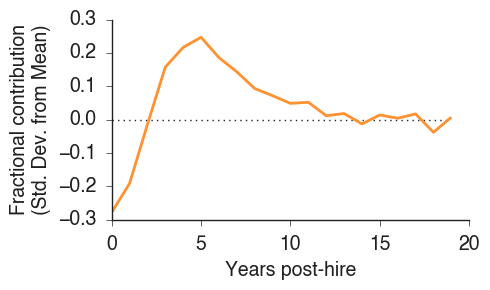

In [34]:
all_before = 2012
all_after = 1970
all_years = np.arange(all_after, all_before)

counts = {year:[] for year in all_years}

for person in asst_faculty:
    # Do they fall in the specified range of years?
    start = int(person.first_asst_job_year)
    if start > all_before or start < all_after:
        continue
    
    if 'dblp_pubs' in person:
        pubs = person['dblp_pubs']
    else:
        pubs = []
    
    contr_years = Counter()
    for pub in pubs:
        if 'year' in pub and pub['year'] >= start and \
           pub['pub_type'] in ['inproceedings', 'article']:
            contr = 1./len(pub['authors'])
            contr_years[pub['year']] += contr

    for year in xrange(person.first_asst_job_year, all_before):
        counts[year].append(contr_years[year])
        
mean_counts = {year:np.mean(counts[int(year)]) for year in all_years}
med_counts = {year:np.median(counts[int(year)]) for year in all_years}
std_counts = {year:np.std(counts[int(year)]) for year in all_years}

# Now the individual values:
max_plot = 20
all_years = np.arange(max_plot)

z_counts = {year:[] for year in all_years}

for person in asst_faculty:
    # Do they fall in the specified range of years?
    start = int(person.first_asst_job_year)
    if start > all_before or start < all_after:
        continue
    
    if 'dblp_pubs' in person:
        pubs = person['dblp_pubs']
    else:
        pubs = []
    
    contr_years = Counter()
    for pub in pubs:
        if 'year' in pub and pub['year'] >= start and \
            pub['pub_type'] in ['inproceedings', 'article']:           
            year_diff = pub['year'] - start
            contr = 1./len(pub['authors'])
            contr_years[year_diff] += contr

    for year in xrange(max_plot):
        if year + start < 2012:
            z = (contr_years[year] - mean_counts[year + start]) / std_counts[year + start]
            z_counts[year].append(z)
        
mean_z_counts = {year:np.mean(z_counts[year]) for year in z_counts}

# Make the figure
fig, ax = plt.subplots(figsize=(5,3))

years = np.arange(max_plot)
traj = np.array([mean_z_counts[y] for y in years])
ax.plot([years[0], years[-1]], [0, 0], ':', color=ALMOST_BLACK)
ax.plot(years, traj, color=ACCENT_COLOR_1, linewidth=LINE_WIDTH)

hide_right_top_axis(ax)
ax.set_ylabel('Fractional contribution\n(Std. Dev. from Mean)', fontsize=LABEL_SIZE)
ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)
ax.set_xlabel('Years post-hire', fontsize=LABEL_SIZE)

finalize(ax)

plt.savefig(figures_dir + 'mean_fractional_contribution.pdf')
plt.show()

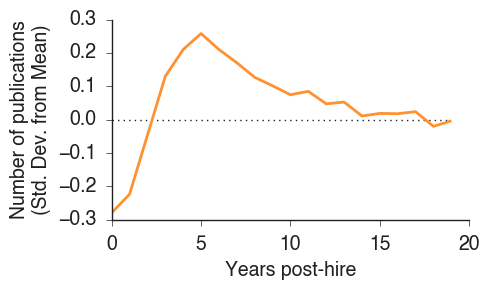

In [35]:
all_before = 2012
all_after = 1970
all_years = np.arange(all_after, all_before)

counts = {year:[] for year in all_years}

for person in asst_faculty:
    # Do they fall in the specified range of years?
    start = int(person.first_asst_job_year)
    if start > all_before or start < all_after:
        continue
    
    if 'dblp_pubs' in person:
        pubs = person['dblp_pubs']
    else:
        pubs = []
    
    contr_years = Counter()
    for pub in pubs:
        if 'year' in pub and pub['year'] >= start and \
           pub['pub_type'] in ['inproceedings', 'article']:
            contr = 1.
            contr_years[pub['year']] += contr

    for year in xrange(person.first_asst_job_year, all_before):
        counts[year].append(contr_years[year])
        
mean_counts = {year:np.mean(counts[int(year)]) for year in all_years}
med_counts = {year:np.median(counts[int(year)]) for year in all_years}
std_counts = {year:np.std(counts[int(year)]) for year in all_years}

# Now the individual values:
max_plot = 20
all_years = np.arange(max_plot)

z_counts = {year:[] for year in all_years}

for person in asst_faculty:
    # Do they fall in the specified range of years?
    start = int(person.first_asst_job_year)
    if start > all_before or start < all_after:
        continue
    
    if 'dblp_pubs' in person:
        pubs = person['dblp_pubs']
    else:
        pubs = []
    
    contr_years = Counter()
    for pub in pubs:
        if 'year' in pub and pub['year'] >= start and \
            pub['pub_type'] in ['inproceedings', 'article']:           
            year_diff = pub['year'] - start
            contr = 1.
            contr_years[year_diff] += contr

    for year in xrange(max_plot):
        if year + start < 2012:
            z = (contr_years[year] - mean_counts[year + start]) / std_counts[year + start]
            z_counts[year].append(z)
        
mean_z_counts = {year:np.mean(z_counts[year]) for year in z_counts}

# Make the figure
fig, ax = plt.subplots(figsize=(5,3))

years = np.arange(max_plot)
traj = np.array([mean_z_counts[y] for y in years])
ax.plot([years[0], years[-1]], [0, 0], ':', color=ALMOST_BLACK)
ax.plot(years, traj, color=ACCENT_COLOR_1, linewidth=LINE_WIDTH)

hide_right_top_axis(ax)
ax.set_ylabel('Number of publications\n(Std. Dev. from Mean)', fontsize=LABEL_SIZE)
ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)
ax.set_xlabel('Years post-hire', fontsize=LABEL_SIZE)

finalize(ax)

plt.savefig(figures_dir + 'mean_contribution.pdf')
plt.show()

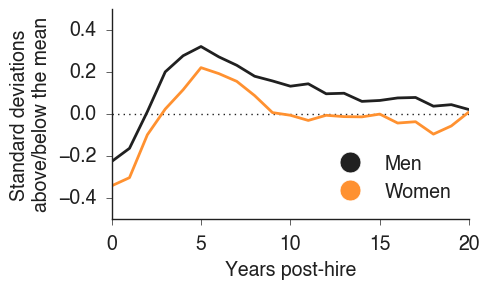

In [23]:
fig, ax = plt.subplots(figsize=(5,3))
years_after = 41
all_before = 2012
all_after = 1970
only_first = 21
min_pubs = 0

A = np.zeros(only_first, dtype=np.float)
B = np.zeros(only_first, dtype=np.float)
A_norm = np.zeros_like(A)
B_norm = np.zeros_like(B)

for person in asst_faculty:
    if 'dblp_pubs' not in person:
        continue 
    if len(person['dblp_pubs']) < min_pubs:
        continue
            
    start = int(person.first_asst_job_year)
    if start > all_before or start < all_after:
        continue
            
    # List of integers representing how many years post-hire each publication occurred. 
    year_diffs = []
    for pub in person['dblp_pubs']:
        if 'year' in pub and pub['year'] >= start and pub['year'] < 2012 and \
           pub['pub_type'] in ['inproceedings', 'article']:
            year_diffs.append(pub['year'] - start)            
                
    pub_counts = Counter(year_diffs)
    traj_length = min(only_first, 2012-start)
    pub_traj = [ (pub_counts[y] - mean_counts[start+y]) / std_counts[start+y] for y in xrange(traj_length)]
   
    if person.is_female:
        add_to = A
        norm = A_norm
    else:
        add_to = B
        norm = B_norm
        
    for i in xrange(traj_length):
        add_to[i] += pub_traj[i]
        norm[i] += 1
        
ax.plot([0, only_first-1], [0, 0], ':', color=ALMOST_BLACK)
ax.plot(A/A_norm, color=ACCENT_COLOR_1, linewidth=LINE_WIDTH, clip_on=True)   
ax.plot(B/B_norm, color=ALMOST_BLACK, linewidth=LINE_WIDTH, clip_on=True)   

ax.set_xlim(0,only_first-1)
ax.set_ylim(-.5,.5)
hide_right_top_axis(ax)
ax.set_ylabel('Standard deviations\nabove/below the mean', fontsize=LABEL_SIZE)
ax.set_xlabel('Years post-hire', fontsize=LABEL_SIZE)

fake_line_all = Line2D(range(1), range(1), color=ALMOST_BLACK, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
fake_line_f = Line2D(range(1), range(1), color=ACCENT_COLOR_1, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
plt.legend((fake_line_all,fake_line_f),('Men','Women'), numpoints=1, loc='lower right', frameon=False, fontsize=LABEL_SIZE)

finalize(ax)

plt.savefig(figures_dir + 'prod_gender.pdf')
plt.show()

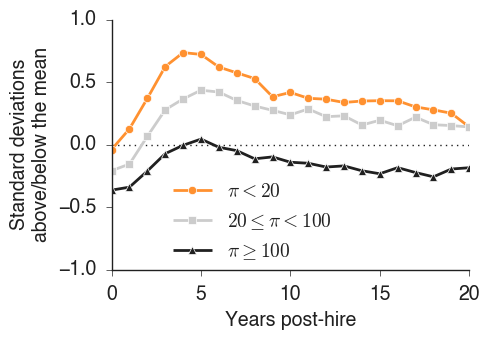

In [67]:
all_before = 2012
all_after = 1970
all_years = np.arange(all_after, all_before)

counts = {year:[] for year in all_years}

for person in asst_faculty:
    # Do they fall in the specified range of years?
    start = int(person.first_asst_job_year)
    if start > all_before or start < all_after:
        continue
    
    if 'dblp_pubs' in person:
        pubs = person['dblp_pubs']
    else:
        pubs = []
    
    contr_years = Counter()
    for pub in pubs:
        if 'year' in pub and pub['year'] >= start and \
           pub['pub_type'] in ['inproceedings', 'article']:
            contr = 1.
            contr_years[pub['year']] += contr

    for year in xrange(person.first_asst_job_year, all_before):
        counts[year].append(contr_years[year])
        
mean_counts = {year:np.mean(counts[int(year)]) for year in all_years}
med_counts = {year:np.median(counts[int(year)]) for year in all_years}
std_counts = {year:np.std(counts[int(year)]) for year in all_years}

fig, ax = plt.subplots(figsize=(5,3.5))
years_after = 41
only_first = 21
min_pubs = 0

A = np.zeros(only_first, dtype=np.float)
B = np.zeros(only_first, dtype=np.float)
C = np.zeros(only_first, dtype=np.float)
A_norm = np.zeros_like(A)
B_norm = np.zeros_like(B)
C_norm = np.zeros_like(C)

for person in asst_faculty:
    if 'dblp_pubs' not in person or len(person['dblp_pubs']) < min_pubs:
        continue 
            
    start = int(person.first_asst_job_year)
    if start >= all_before or start < all_after:
        continue
            
    # List of integers representing how many years post-hire each publication occurred. 
    year_diffs = []
    for pub in person['dblp_pubs']:
        if 'year' in pub and pub['year'] >= start and pub['year'] < 2012 and \
           pub['pub_type'] in ['inproceedings', 'article']:
            year_diffs.append(pub['year'] - start)            
                
    pub_counts = Counter(year_diffs)
    traj_length = min(only_first, 2012-start)
    pub_traj = [ (pub_counts[y] - mean_counts[start+y]) / std_counts[start+y] for y in xrange(traj_length)]
   
    if person.first_asst_job_rank < 20: 
        add_to = A
        norm = A_norm
    elif person.first_asst_job_rank < 100:
        add_to = B
        norm = B_norm
    else:
        add_to = C
        norm = C_norm
        
    for i in xrange(traj_length):
        add_to[i] += pub_traj[i]
        norm[i] += 1
        
ax.plot([0, only_first-1], [0, 0], ':', color=ALMOST_BLACK)
ax.plot(A/A_norm, '-o', color=ACCENT_COLOR_1, linewidth=LINE_WIDTH, 
        clip_on=True, markeredgecolor='w', label=r'$\pi < 20$')   
ax.plot(B/B_norm, '-s', color=LIGHT_COLOR, linewidth=LINE_WIDTH, 
        clip_on=True, markeredgecolor='w', label=r'$20 \leq \pi < 100$')   
ax.plot(C/C_norm, '-^', color=ALMOST_BLACK, linewidth=LINE_WIDTH, 
        clip_on=True, markeredgecolor='w', label=r'$\pi \geq 100$')   

ax.set_xlim(0,only_first-1)
ax.set_ylim(-1,1.)
hide_right_top_axis(ax)
ax.set_ylabel('Standard deviations\nabove/below the mean', fontsize=LABEL_SIZE)
ax.set_xlabel('Years post-hire', fontsize=LABEL_SIZE)

"""fake_line_f = Line2D(range(1), range(1), color=ACCENT_COLOR_1, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
fake_line_all = Line2D(range(1), range(1), color=ALMOST_BLACK, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
plt.legend((fake_line_f,fake_line_all),('Top-20','Everyone else'), numpoints=1, loc='lower right', frameon=False, fontsize=LABEL_SIZE)
"""
plt.legend(numpoints=1, fontsize=LABEL_SIZE, frameon=False, loc=(0.15,0.))
ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)

finalize(ax)

plt.savefig(figures_dir + 'prod_by_rank.pdf')

plt.show()

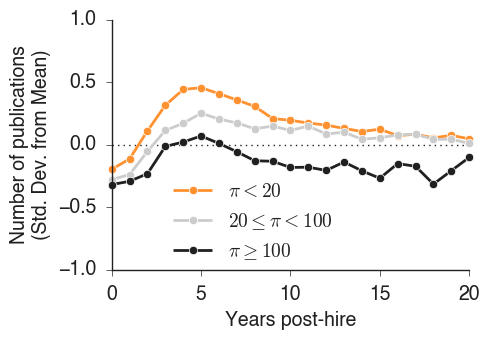

In [95]:
all_before = 2012
all_after = 1970
all_years = np.arange(all_after, all_before)

counts = {year:[] for year in all_years}

for person in asst_faculty:
    # Do they fall in the specified range of years?
    start = int(person.first_asst_job_year)
    if start > all_before or start < all_after:
        continue
    
    if 'dblp_pubs' in person:
        pubs = person['dblp_pubs']
    else:
        pubs = []
    
    contr_years = Counter()
    for pub in pubs:
        if 'year' in pub and pub['year'] >= start and \
           pub['pub_type'] in ['inproceedings', 'article']:
            contr = 1.
            contr_years[pub['year']] += contr

    for year in xrange(person.first_asst_job_year, all_before):
        counts[year].append(contr_years[year])
        
mean_counts = {year:np.mean(counts[int(year)]) for year in all_years}
med_counts = {year:np.median(counts[int(year)]) for year in all_years}
std_counts = {year:np.std(counts[int(year)]) for year in all_years}

fig, ax = plt.subplots(figsize=(5,3.5))
years_after = 41
only_first = 21
min_pubs = 0

A = np.zeros(only_first, dtype=np.float)
B = np.zeros(only_first, dtype=np.float)
C = np.zeros(only_first, dtype=np.float)
A_norm = np.zeros_like(A)
B_norm = np.zeros_like(B)
C_norm = np.zeros_like(C)

for person in asst_faculty:
    if 'dblp_pubs' not in person or len(person['dblp_pubs']) < min_pubs:
        continue 
            
    start = int(person.first_asst_job_year)
    if start >= all_before or start < all_after:
        continue
            
    # List of integers representing how many years post-hire each publication occurred. 
    year_diffs = []
    for pub in person['dblp_pubs']:
        if 'year' in pub and pub['year'] >= start and pub['year'] < 2012 and \
           pub['pub_type'] in ['inproceedings', 'article']:
            year_diffs.append(pub['year'] - start)            
                
    pub_counts = Counter(year_diffs)
    traj_length = min(only_first, 2012-start)
    pub_traj = [ (pub_counts[y] - mean_counts[start+y]) / std_counts[start+y] for y in xrange(traj_length)]
   
    if person.phd_rank < 20: 
        add_to = A
        norm = A_norm
    elif person.phd_rank < 100:
        add_to = B
        norm = B_norm
    else:
        add_to = C
        norm = C_norm
        
    for i in xrange(traj_length):
        add_to[i] += pub_traj[i]
        norm[i] += 1
        
ax.plot([0, only_first-1], [0, 0], ':', color=ALMOST_BLACK)
ax.plot(A/A_norm, '-o', color=ACCENT_COLOR_1, linewidth=LINE_WIDTH, 
        clip_on=False, markeredgecolor='w', label=r'$\pi < 20$')   
ax.plot(B/B_norm, '-o', color=LIGHT_COLOR, linewidth=LINE_WIDTH, 
        clip_on=False, markeredgecolor='w', label=r'$20 \leq \pi < 100$')   
ax.plot(C/C_norm, '-o', color=ALMOST_BLACK, linewidth=LINE_WIDTH, 
        clip_on=False, markeredgecolor='w', label=r'$\pi \geq 100$')   

ax.set_xlim(0,only_first-1)
ax.set_ylim(-1,1.)
hide_right_top_axis(ax)
ax.set_ylabel('Number of publications\n(Std. Dev. from Mean)', fontsize=LABEL_SIZE)
ax.set_xlabel('Years post-hire', fontsize=LABEL_SIZE)

"""fake_line_f = Line2D(range(1), range(1), color=ACCENT_COLOR_1, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
fake_line_all = Line2D(range(1), range(1), color=ALMOST_BLACK, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
plt.legend((fake_line_f,fake_line_all),('Top-20','Everyone else'), numpoints=1, loc='lower right', frameon=False, fontsize=LABEL_SIZE)
"""
plt.legend(numpoints=1, fontsize=LABEL_SIZE, frameon=False, loc=(0.15,0.))
ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)

finalize(ax)

plt.savefig(figures_dir + 'prod_by_PHD_rank.pdf')

plt.show()

## How many coauthors?

In [70]:
all_before = 2012
all_after = 1970

counts = {year:[] for year in xrange(all_after, all_before)}
male_counts = {year:[] for year in xrange(all_after, all_before)}
female_counts = {year:[] for year in xrange(all_after, all_before)}

for person in asst_faculty:
    # Do they fall in the specified range of years?
    start = int(person.first_asst_job_year)
    if start > all_before or start < all_after:
        continue
    
    if 'dblp_pubs' in person:
        pubs = person['dblp_pubs']
    else:
        pubs = []
    
    if person.is_female:
        gender_counts = female_counts
    else:
        gender_counts = male_counts
    
    years = []
    for pub in pubs:
        if 'year' in pub and pub['year'] >= start and pub['year'] < 2012 and \
           pub['pub_type'] in ['inproceedings', 'article']:
            counts[pub['year']].append(len(pub['authors']))
            gender_counts[pub['year']].append(len(pub['authors']))
        
mean_counts = {year:np.mean(counts[year]) for year in counts}
med_counts = {year:np.median(counts[year]) for year in counts}
std_counts = {year:np.std(counts[year]) for year in counts}

male_mean_counts = {year:np.mean(male_counts[year]) for year in counts}
female_mean_counts = {year:np.mean(female_counts[year]) for year in counts}

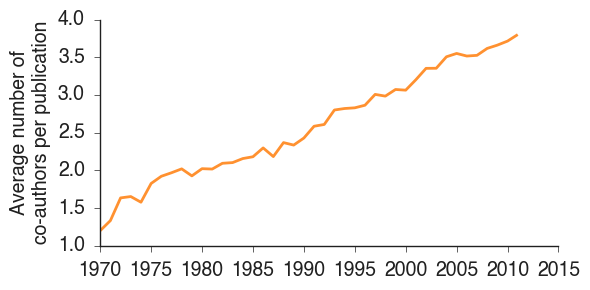

In [71]:
fig, ax = plt.subplots(figsize=(6,3))

years = np.arange(1970, 2012)
traj = np.array([mean_counts[y] for y in years])
ax.plot(years, traj, color=ACCENT_COLOR_1, linewidth=LINE_WIDTH)
#ax.text(1995, 2.5, r'$\leftarrow$ Trump Orange')
hide_right_top_axis(ax)
ax.set_ylabel('Average number of\nco-authors per publication', fontsize=LABEL_SIZE)
ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)

finalize(ax)

plt.savefig(figures_dir + 'prod_coauthors.pdf')
plt.show()

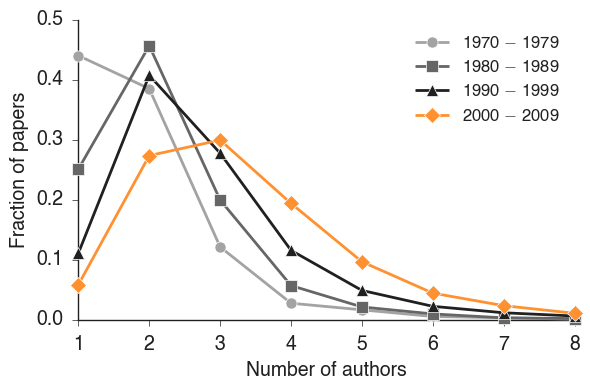

In [72]:
fig, ax = plt.subplots(figsize=(6,4))

starts = [1970, 1980, 1990, 2000]
years_following = 10
num_bins = 8
bins = np.arange(num_bins+1)

line_styles = ['o-','s-','^-','D-']
line_colors = [LIGHT_COLOR_V*.8, DARK_COLOR, ALMOST_BLACK, ACCENT_COLOR_1]

for s, start in enumerate(starts):
    multiyear_counts = []
    for i in xrange(years_following):
        multiyear_counts += counts[start + i]
        
    vals, bounds = np.histogram(multiyear_counts, bins=bins+0.5, weights=np.ones_like(multiyear_counts, dtype=float)/len(multiyear_counts))
    vals /= vals.sum()
    label = '%d $-$ %d' % (start, start+years_following-1)
    ax.plot(vals, line_styles[s], linewidth=LINE_WIDTH, markersize=8, markeredgecolor='w', 
            color=line_colors[s], label=r'%s'%label, clip_on=False, zorder=10+s)
    
    #ax.scatter(np.mean(multiyear_counts), 0, clip_on=False, color=line_colors[s], zorder=100, 
    #           marker=line_styles[s][:1], s=8)
    mu = np.mean(multiyear_counts)
    #ax.plot([mu,mu], [0,0], line_styles[s], linewidth=LINE_WIDTH, markersize=8, markeredgecolor='w', 
    #        color=line_colors[s], clip_on=False, zorder=10+s)
        
ax.set_xticks(np.arange(num_bins))
ax.set_xticklabels(np.arange(num_bins)+1)

#fake_line_f = Line2D(range(1), range(1), color=ACCENT_COLOR_1, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
#fake_line_all = Line2D(range(1), range(1), color=ALMOST_BLACK, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
#plt.legend((fake_line_f,fake_line_all),('Women','Men'), numpoints=1, 
#           frameon=False, fontsize=LABEL_SIZE, ncol=1,
#           loc='upper center', bbox_to_anchor=(.26, 1.025))
plt.legend(frameon=False, numpoints=1)

ax.set_ylabel('Fraction of papers')
ax.set_xlabel('Number of authors')

ax.set_ylim(0, 0.5)
ax.set_xlim(0,num_bins-1)
        
finalize(ax)
plt.savefig(figures_dir + 'prod_coauthors_dists.pdf')
plt.show()

## How does the multinomial change over time?

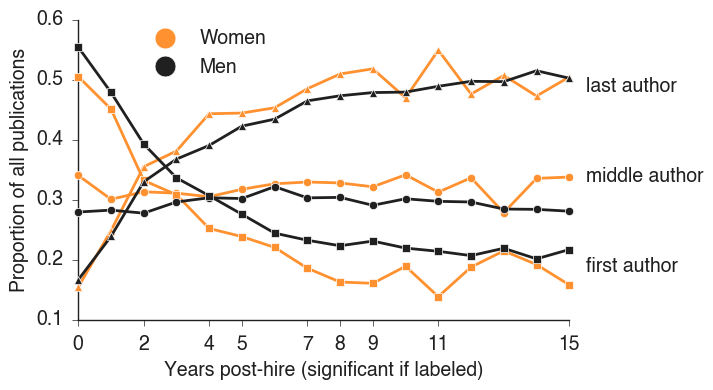

In [73]:
fig, ax = plt.subplots(figsize=(6,4))
all_before = 2012
all_after = 1970
max_size = all_before - all_after
min_pubs = 0
just_first = 16
lower = 0.1
upper = 0.6

A = np.zeros((3, max_size), dtype=np.float)  # 3 --> First, Middle, and Last Author Counts
B = np.zeros((3, max_size), dtype=np.float)

for person in asst_faculty:
    if 'dblp_pubs' not in person:
        continue 
    if len(person['dblp_pubs']) < min_pubs:
        continue
    # Do they fall in the specified range of years?
    start = int(person.first_asst_job_year)
    if start > all_before or start < all_after:
        continue
            
    for pub in person['dblp_pubs']:
        if 'year' in pub and pub['year'] >= start and pub['year'] < 2012 and \
           pub['pub_type'] in ['inproceedings', 'article']:
            year_offset = pub['year'] - start
            
            # What kind of publication is it? (First/middle/last?)
            type_index = pub['author_role']
                
            if person.is_female:
                A[type_index][year_offset] += 1
            else:
                B[type_index][year_offset] += 1

# Significant?
sig = np.zeros(just_first, dtype=int)
label = []
for i in xrange(just_first):
    c2, p, dof, ex = chi2_contingency([A[:,i], B[:,i]])
    sig[i] = int(p < 0.05)
    if sig[i]:
        label.append(i)
                
# Normalize!
A_sums = np.sum(A, axis=0)
B_sums = np.sum(B, axis=0)
A /= A_sums[np.newaxis, :]
B /= B_sums[np.newaxis, :]

# WOMEN
ax.plot(xrange(just_first), A[2,:just_first], '^-', linewidth=LINE_WIDTH, color=ACCENT_COLOR_1, markeredgecolor='w', clip_on=False, zorder=100)
ax.plot(xrange(just_first), A[1,:just_first], 'o-', linewidth=LINE_WIDTH, color=ACCENT_COLOR_1, markeredgecolor='w', clip_on=False, zorder=100)
ax.plot(xrange(just_first), A[0,:just_first], 's-', linewidth=LINE_WIDTH, color=ACCENT_COLOR_1, markeredgecolor='w', clip_on=False, zorder=100)

# MEN
ax.plot(xrange(just_first), B[2,:just_first], '^-', linewidth=LINE_WIDTH, color=ALMOST_BLACK, markeredgecolor='w', clip_on=False, zorder=100)
ax.plot(xrange(just_first), B[1,:just_first], 'o-', linewidth=LINE_WIDTH, color=ALMOST_BLACK, markeredgecolor='w', clip_on=False, zorder=100)
ax.plot(xrange(just_first), B[0,:just_first], 's-', linewidth=LINE_WIDTH, color=ALMOST_BLACK, markeredgecolor='w', clip_on=False, zorder=100)

'''
# WOMEN
last = A[2,:just_first]
last_mid = last + A[1,:just_first]
ax.fill_between(xrange(just_first), last, last_mid, color=FEMALE_COLOR)

# MEN
last = B[2,:just_first]
last_mid = last + B[1,:just_first]
ax.fill_between(xrange(just_first), last, last_mid, color=DARK_COLOR, alpha=0.5)
'''

ax.text(just_first-0.5, 0.48, 'last author', fontsize=LABEL_SIZE)
ax.text(just_first-0.5, 0.33, 'middle author', fontsize=LABEL_SIZE)
ax.text(just_first-0.5, 0.18, 'first author', fontsize=LABEL_SIZE)

ax.set_xticks(label)
ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)
ax.set_xlabel('Years post-hire (significant if labeled)', fontsize=LABEL_SIZE)
ax.set_ylabel('Proportion of all publications', fontsize=LABEL_SIZE)
ax.set_xlim(0,just_first-1)
ax.set_ylim(0.1, 0.6)

finalize(ax) 

fake_line_f = Line2D(range(1), range(1), color=ACCENT_COLOR_1, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
fake_line_all = Line2D(range(1), range(1), color=ALMOST_BLACK, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
plt.legend((fake_line_f,fake_line_all),('Women','Men'), numpoints=1, 
           frameon=False, fontsize=LABEL_SIZE, ncol=1,
           loc='upper center', bbox_to_anchor=(.26, 1.025))

plt.tight_layout()
plt.savefig(figures_dir + 'pubtype_gender.pdf', bbox_inches='tight')
plt.show()

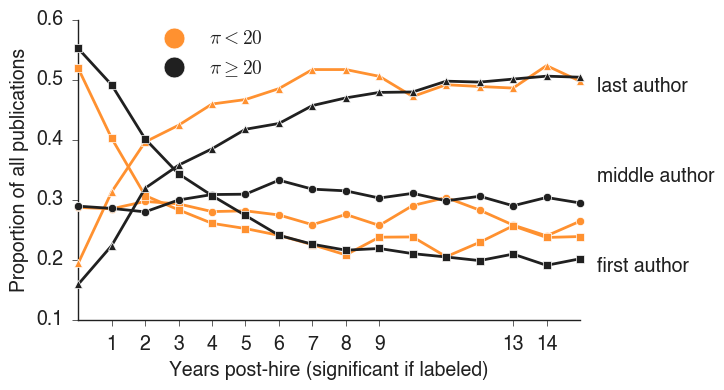

In [76]:
fig, ax = plt.subplots(figsize=(6,4))
all_before = 2012
all_after = 1970
max_size = all_before - all_after
min_pubs = 0
just_first = 16
lower = 0.1
upper = 0.6

A = np.zeros((3, max_size), dtype=np.float)  # 3 --> First, Middle, and Last Author Counts
B = np.zeros((3, max_size), dtype=np.float)

for person in asst_faculty:
    if 'dblp_pubs' not in person:
        continue 
    if len(person['dblp_pubs']) < min_pubs:
        continue
    # Do they fall in the specified range of years?
    start = int(person.first_asst_job_year)
    if start > all_before or start < all_after:
        continue
            
    for pub in person['dblp_pubs']:
        if 'year' in pub and pub['year'] >= start and pub['year'] < 2012 and \
           pub['pub_type'] in ['inproceedings', 'article']:
            year_offset = pub['year'] - start
            
            # What kind of publication is it? (First/middle/last?)
            type_index = pub['author_role']
                
            if person.first_asst_job_rank < 20:
                A[type_index][year_offset] += 1
            else:
                B[type_index][year_offset] += 1

# Significant?
sig = np.zeros(just_first, dtype=int)
label = []
for i in xrange(just_first):
    c2, p, dof, ex = chi2_contingency([A[:,i], B[:,i]])
    sig[i] = int(p < 0.05)
    if sig[i]:
        label.append(i)
                
# Normalize!
A_sums = np.sum(A, axis=0)
B_sums = np.sum(B, axis=0)
A /= A_sums[np.newaxis, :]
B /= B_sums[np.newaxis, :]

ax.plot(xrange(just_first), A[2,:just_first], '^-', linewidth=LINE_WIDTH, color=ACCENT_COLOR_1, markeredgecolor='w', clip_on=False, zorder=100)
ax.plot(xrange(just_first), A[1,:just_first], 'o-', linewidth=LINE_WIDTH, color=ACCENT_COLOR_1, markeredgecolor='w', clip_on=False, zorder=100)
ax.plot(xrange(just_first), A[0,:just_first], 's-', linewidth=LINE_WIDTH, color=ACCENT_COLOR_1, markeredgecolor='w', clip_on=False, zorder=100)

ax.plot(xrange(just_first), B[2,:just_first], '^-', linewidth=LINE_WIDTH, color=ALMOST_BLACK, markeredgecolor='w', clip_on=False, zorder=100)
ax.plot(xrange(just_first), B[1,:just_first], 'o-', linewidth=LINE_WIDTH, color=ALMOST_BLACK, markeredgecolor='w', clip_on=False, zorder=100)
ax.plot(xrange(just_first), B[0,:just_first], 's-', linewidth=LINE_WIDTH, color=ALMOST_BLACK, markeredgecolor='w', clip_on=False, zorder=100)

ax.text(just_first-0.5, 0.48, 'last author', fontsize=LABEL_SIZE)
ax.text(just_first-0.5, 0.33, 'middle author', fontsize=LABEL_SIZE)
ax.text(just_first-0.5, 0.18, 'first author', fontsize=LABEL_SIZE)

ax.set_xticks(label)
ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)
ax.set_xlabel('Years post-hire (significant if labeled)', fontsize=LABEL_SIZE)
ax.set_ylabel('Proportion of all publications', fontsize=LABEL_SIZE)
ax.set_xlim(0,just_first-1)
ax.set_ylim(0.1, 0.6)

finalize(ax) 

fake_line_f = Line2D(range(1), range(1), color=ACCENT_COLOR_1, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
fake_line_all = Line2D(range(1), range(1), color=ALMOST_BLACK, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
plt.legend((fake_line_f,fake_line_all),(r'$\pi < 20$','$\pi \geq 20$'), numpoints=1, 
           frameon=False, fontsize=LABEL_SIZE, ncol=1,
           loc='upper center', bbox_to_anchor=(.26, 1.025))

plt.tight_layout()
plt.savefig(figures_dir + 'pubtype_by_rank.pdf', bbox_inches='tight')
plt.show()

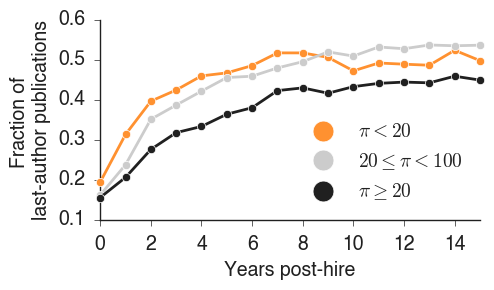

In [92]:
fig, ax = plt.subplots(figsize=(5,3))
all_before = 2012
all_after = 1970
max_size = all_before - all_after
min_pubs = 0
just_first = 16
lower = 0.1
upper = 0.6

A = np.zeros((3, max_size), dtype=np.float)  # 3 --> First, Middle, and Last Author Counts
B = np.zeros((3, max_size), dtype=np.float)
C = np.zeros((3, max_size), dtype=np.float)

for person in asst_faculty:
    if 'dblp_pubs' not in person:
        continue 
    if len(person['dblp_pubs']) < min_pubs:
        continue
    # Do they fall in the specified range of years?
    start = int(person.first_asst_job_year)
    if start > all_before or start < all_after:
        continue
            
    for pub in person['dblp_pubs']:
        if 'year' in pub and pub['year'] >= start and pub['year'] < 2012 and \
           pub['pub_type'] in ['inproceedings', 'article']:
            year_offset = pub['year'] - start
            
            # What kind of publication is it? (First/middle/last?)
            type_index = pub['author_role']
                
            if person.first_asst_job_rank < 20:
                A[type_index][year_offset] += 1
            elif person.first_asst_job_rank < 100:
                B[type_index][year_offset] += 1
            else:
                C[type_index][year_offset] += 1

# Significant?
"""
sig = np.zeros(just_first, dtype=int)
label = []
for i in xrange(just_first):
    c2, p, dof, ex = chi2_contingency([A[:,i], B[:,i]])
    sig[i] = int(p < 0.05)
    if sig[i]:
        label.append(i)
"""
                
# Normalize!
A_sums = np.sum(A, axis=0)
B_sums = np.sum(B, axis=0)
C_sums = np.sum(C, axis=0)
A /= A_sums[np.newaxis, :]
B /= B_sums[np.newaxis, :]
C /= C_sums[np.newaxis, :]

ax.plot(xrange(just_first), A[2,:just_first], 'o-', linewidth=LINE_WIDTH, color=ACCENT_COLOR_1, markeredgecolor='w', clip_on=False, zorder=100)
ax.plot(xrange(just_first), B[2,:just_first], 'o-', linewidth=LINE_WIDTH, color=LIGHT_COLOR, markeredgecolor='w', clip_on=False, zorder=100)
ax.plot(xrange(just_first), C[2,:just_first], 'o-', linewidth=LINE_WIDTH, color=ALMOST_BLACK, markeredgecolor='w', clip_on=False, zorder=100)

#ax.set_xticks(label)
ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)
ax.set_xlabel('Years post-hire', fontsize=LABEL_SIZE)
ax.set_ylabel('Fraction of \nlast-author publications', fontsize=LABEL_SIZE)
ax.set_xlim(0,just_first-1)
ax.set_ylim(0.1, 0.6)

finalize(ax) 

fake_line1 = Line2D(range(1), range(1), color=ACCENT_COLOR_1, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
fake_line2 = Line2D(range(1), range(1), color=LIGHT_COLOR, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
fake_line3 = Line2D(range(1), range(1), color=ALMOST_BLACK, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
plt.legend((fake_line1, fake_line2, fake_line3),(r'$\pi < 20$', r'$20 \leq \pi < 100$', '$\pi \geq 20$'), numpoints=1, 
           frameon=False, fontsize=LABEL_SIZE, ncol=1,
           loc='lower right') #, bbox_to_anchor=(.26, 1.025))

plt.tight_layout()
#plt.savefig(figures_dir + 'laps_by_rank.pdf', bbox_inches='tight')
plt.show()